In [1]:
from matplotlib import pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

from dataset.ki import KIDataset
from models.rocket import ROCKET
from utils.const import SEED
from utils.data import binarize
from utils.misc import set_random_state

set_random_state(SEED)
!conda activate eyetrackpdc

# Data parameters
BINARY_CLF = True

# Rocket parameters
NUM_KERNELS = 1000
NORMALIZE = True

# Classifier parameters
REG_FACTOR = 1e5

## Initialize Datasets and Dataloaders

In [2]:
# Initialize Datasets
train_ds = KIDataset(train=True, which='segments', config='ki_auto', ki_data_dirname='ki',
                     data_sources=['HC', 'PD_OFF', 'PD_ON'])
test_ds = KIDataset(train=False, which='segments', config='ki_auto', ki_data_dirname='ki',
                    data_sources=['HC', 'PD_OFF', 'PD_ON'])
if BINARY_CLF:
    binarize(train_ds)
    binarize(test_ds)

# Revert dimensions. TODO this should not be needed
train_ds.x = train_ds.x.permute(0, 2, 1)
test_ds.x = test_ds.x.permute(0, 2, 1)

# Initialize Dataloaders
train_dl = DataLoader(train_ds,
                      batch_size=train_ds.x.shape[0],
                      sampler=ImbalancedDatasetSampler(train_ds, callback_get_label=lambda item: item.y))
test_dl = DataLoader(test_ds, batch_size=test_ds.x.shape[0])

[KIDataset] datapoint distribution over 2160 points:
			PD_OFF: 36.99%
			PD_ON: 38.98%
			HC: 24.03%
[KIDataset] datapoint distribution over 940 points:
			PD_OFF: 40.85%
			PD_ON: 27.45%
			HC: 31.70%


## Initialize Rocket and classifier

In [3]:
# Initialize Rocket
rocket = ROCKET(c_in=train_ds.x.shape[1],
                seq_len=train_ds.x.shape[2],
                n_kernels=NUM_KERNELS,
                normalize=NORMALIZE)

# Initialize Classifier
clf = RidgeClassifier(alpha=REG_FACTOR, random_state=SEED)

## Fit Model

In [4]:
# Batch is entire dataset
train_batch = next(iter(train_dl))

# Perform ROCKET transformation stage
features = rocket(train_batch.x)

# Fit Classifier
clf.fit(features, train_batch.y)

RidgeClassifier(alpha=100000.0, random_state=42)

## Evaluate on segment classification

Segment classification on test set:
              precision    recall  f1-score   support

          HC       0.29      0.46      0.35       298
          PD       0.65      0.47      0.54       642

    accuracy                           0.47       940
   macro avg       0.47      0.47      0.45       940
weighted avg       0.54      0.47      0.48       940



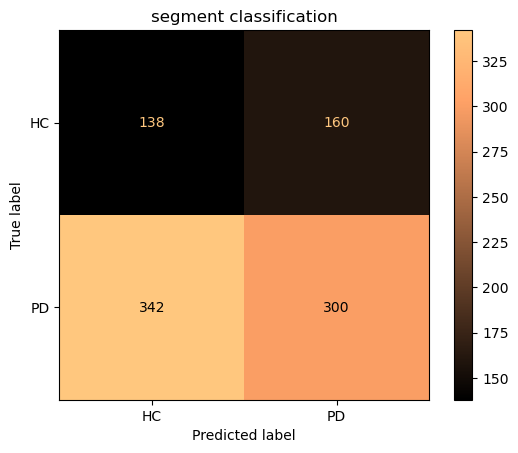

In [5]:
labels = ['HC', 'PD']
test_batch = next(iter(test_dl))

# Perform ROCKET transformation stage
test_features = rocket(test_batch.x)

# Make predictions on test set
pred = clf.predict(test_features)

# The RidgeClassifier maps the targets to {-1, 1}, but our labels are {0, 1}
pred[pred < 0] = 0

# Compute metrics
report = classification_report(test_batch.y.numpy(), pred, target_names=labels)

# Construct the confusion matrix
cf_matrix = confusion_matrix(test_batch.y, pred)

# Plot metrics and display confusion matrix
print(f'Segment classification on test set:\n{report}')
figure = ConfusionMatrixDisplay(cf_matrix, display_labels=labels).plot(cmap='copper')
figure.ax_.set_title('segment classification')
plt.show()